In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy
import math
import random
import cvxopt
from cvxopt import matrix, solvers
%matplotlib inline

In [2]:
# tickers_list = ['AAPL', 'TSLA', 'IBM', 'NFLX', 'FB', 'AXP', 'COKE', 'GOOG', 'AMZN', 'WMT']
tickers_list = ['BTI.JO', 'SBK.JO', 'CPI.JO', 'KIO.JO', 'BHP.JO', 'CFR.JO', 'AGL.JO', 'MTN.JO', 'NPN.JO', 'SOL.JO']
# tickers_list = ['AMS.JO', 'BHP.JO', 'BTI.JO', 'CPI.JO', 'DSY.JO', 'GLN.JO', 'KIO.JO', 'MTN.JO', 'NPN.JO', 'SBK.JO']
# tickers_list = ['CPI.JO', 'KIO.JO', 'AGL.JO']
data = yf.download(tickers_list,'2016-1-1')['Adj Close']


[*********************100%***********************]  10 of 10 completed


In [3]:
data.head()

,AGL.JO,BHP.JO,BTI.JO,CFR.JO,CPI.JO,KIO.JO,MTN.JO,NPN.JO,SBK.JO,SOL.JO
Date,,,,,,,,,,
2016-01-01,5695.215332,13426.063477,71999.195312,9739.947266,49559.128906,2368.635254,9618.330078,131240.765625,8312.963867,37495.671875
2016-01-04,5356.754883,13121.944336,69973.140625,9417.900391,48771.425781,2100.726807,9402.645508,127526.421875,8153.297363,36816.210938
2016-01-05,5406.285645,13205.307617,69754.625000,9339.352539,48219.292969,2078.304443,9927.384766,125977.523438,8180.396484,37102.304688
2016-01-06,5058.743652,12561.559570,70328.546875,9225.019531,47915.621094,1955.273682,9611.092773,123811.445312,8129.860352,36472.007812
2016-01-07,4741.747070,12107.695312,70594.890625,9266.041016,47851.214844,1810.970825,9137.740234,118921.476562,7885.964355,34686.625000


# Time Series

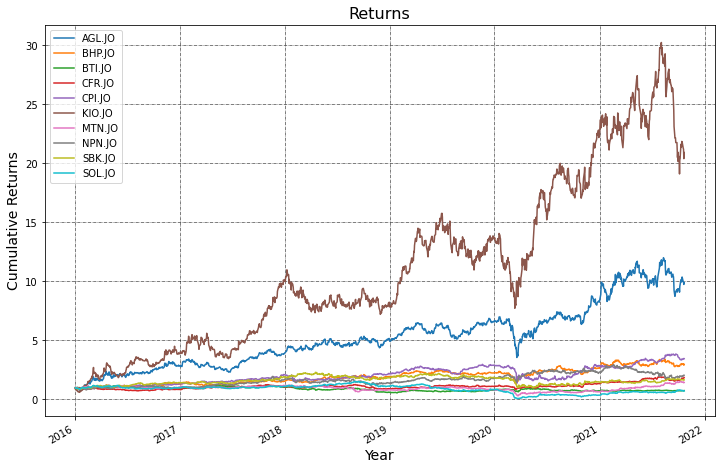

In [4]:
# from matplotlib import cm

# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(12, 8))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

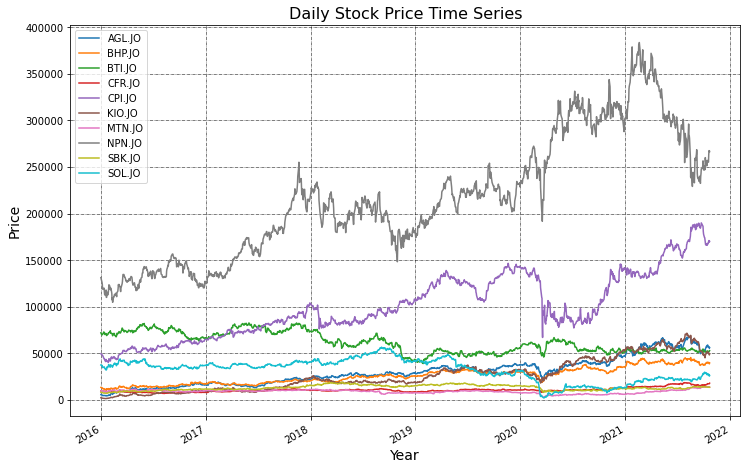

In [5]:
# Plot all the close prices
data.plot(figsize=(12, 8))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Daily Stock Price Time Series", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [6]:
rates = data.pct_change()
rates.head()
# print(rates.to_latex(index=True)) 

,AGL.JO,BHP.JO,BTI.JO,CFR.JO,CPI.JO,KIO.JO,MTN.JO,NPN.JO,SBK.JO,SOL.JO
Date,,,,,,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,-0.059429,-0.022651,-0.028140,-0.033065,-0.015894,-0.113107,-0.022424,-0.028302,-0.019207,-0.018121
2016-01-05,0.009246,0.006353,-0.003123,-0.008340,-0.011321,-0.010674,0.055808,-0.012146,0.003324,0.007771
2016-01-06,-0.064285,-0.048749,0.008228,-0.012242,-0.006298,-0.059198,-0.031861,-0.017194,-0.006178,-0.016988
2016-01-07,-0.062663,-0.036131,0.003787,0.004447,-0.001344,-0.073802,-0.049251,-0.039495,-0.030000,-0.048952


In [7]:
ui = rates.iloc[1:,:]
gmean = ((ui+1).product())**(1/len(ui)) - 1
gmean = pd.DataFrame(gmean)
gmean.columns = ['Returns']

In [8]:
cov = rates.cov()
cov
# print(cov.to_latex(index=True)) 

,AGL.JO,BHP.JO,BTI.JO,CFR.JO,CPI.JO,KIO.JO,MTN.JO,NPN.JO,SBK.JO,SOL.JO
AGL.JO,0.000742,0.000458,0.000059,0.000167,0.000183,0.000528,0.000221,0.000165,0.000184,0.000421
BHP.JO,0.000458,0.000436,0.000071,0.000147,0.000103,0.000379,0.000151,0.000136,0.000109,0.000325
BTI.JO,0.000059,0.000071,0.000284,0.000091,0.000005,0.000037,0.000057,0.000039,-0.000006,0.000090
CFR.JO,0.000167,0.000147,0.000091,0.000283,0.000059,0.000107,0.000062,0.000086,0.000043,0.000186
CPI.JO,0.000183,0.000103,0.000005,0.000059,0.000597,0.000141,0.000179,0.000113,0.000301,0.000198
KIO.JO,0.000528,0.000379,0.000037,0.000107,0.000141,0.001220,0.000174,0.000150,0.000153,0.000341
MTN.JO,0.000221,0.000151,0.000057,0.000062,0.000179,0.000174,0.000791,0.000105,0.000282,0.000404
NPN.JO,0.000165,0.000136,0.000039,0.000086,0.000113,0.000150,0.000105,0.000471,0.000111,0.000135
SBK.JO,0.000184,0.000109,-0.000006,0.000043,0.000301,0.000153,0.000282,0.000111,0.000476,0.000306
SOL.JO,0.000421,0.000325,0.000090,0.000186,0.000198,0.000341,0.000404,0.000135,0.000306,0.001624


In [9]:
vol = rates.var()**0.5
vol = pd.DataFrame(vol)
vol.columns = ['volatility']

# print(vol.to_latex(index=False)) 

In [10]:
corr = rates.corr()
corr = corr.values
# print(corr.to_latex(index=True)) 

In [11]:
num_portfolios = 500
p_weights = []
p_returns = []
p_risk = []
sharpe = []


for portfolio in range(num_portfolios):
    #generate random weights
    w = np.random.random_sample(len(rates.columns))
    w = np.round(w/sum(w), 3)
    p_weights.append(w)
    
    #calculate annualised return
    a_r = np.sum(rates.mean() * w) * 252
    p_returns.append(a_r)
    
    #covariance and risk
    m_c = rates.cov() * 252
    var = np.dot(w.T,
                np.dot(m_c, w))
    std = np.sqrt(var)
    p_risk.append(std)
    
    #sharpe
    sharpe.append(a_r/std)
    

# Efficient Frontier

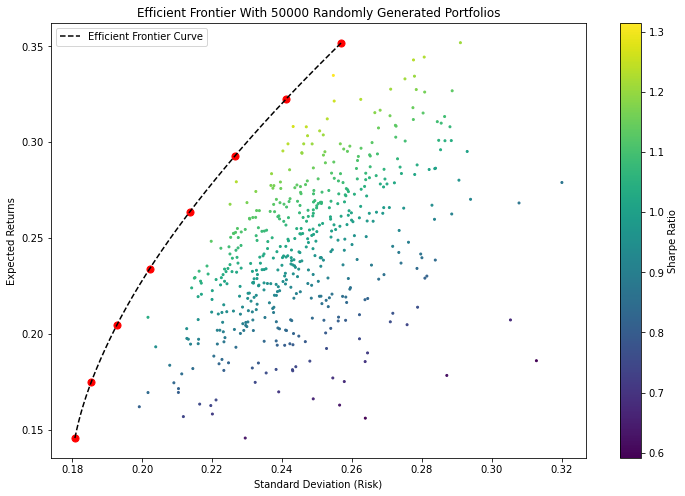

In [12]:
from scipy.optimize import minimize
return_mean = rates.mean()
Sigma = rates.cov()*252
returns = p_returns
# returns = [0, 0.4]

def negativeSR(w):
    w = np.array(w)
    R = np.sum(return_mean*w)*252
    V = np.sqrt(np.dot(w.T,np.dot(Sigma,w)))
    SR = R/V   
    return -1*SR

def checkSumToOne(w):
    return np.sum(w)-1


w0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

constraints = ({'type':'eq', 'fun':checkSumToOne})
w_opt = minimize(negativeSR, w0, method = 'SLSQP', bounds = bounds, constraints=constraints)



frontier_y = np.linspace(min(returns),max(returns),500)
frontier_points = np.linspace(min(returns),max(returns),8)
volatility_opt = []
volatility_points =[]
def minimizeMyVolatilty(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(Sigma,w)))
    return V

def getReturn(w):
    w = np.array(w)
    R = np.sum(return_mean*w)*252
    return R
    
for R in frontier_y:
    #find best vol
    constraints = ({'type':'eq', 'fun':checkSumToOne},
                    {'type':'eq', 'fun': lambda w: getReturn(w)-R})
    opt = minimize(minimizeMyVolatilty, w0, method = 'SLSQP', bounds = bounds, constraints=constraints)
    volatility_opt.append(opt['fun'])
    
for R in frontier_points:
    #find best vol
    constraints = ({'type':'eq', 'fun':checkSumToOne},
                    {'type':'eq', 'fun': lambda w: getReturn(w)-R})
    opt = minimize(minimizeMyVolatilty, w0, method = 'SLSQP', bounds = bounds, constraints=constraints)
    volatility_points.append(opt['fun'])
    
    
    
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(volatility_opt, frontier_y, color = 'black', linestyle='--' )
plt.scatter(volatility_points, frontier_points, color = 'r', s = 50 )
plt.scatter(p_risk, p_returns, c = sharpe, s =4)
plt.title('Efficient Frontier With 50000 Randomly Generated Portfolios')
plt.legend(['Efficient Frontier Curve'], loc=2)
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Returns')
plt.colorbar(label = "Sharpe Ratio")
plt.show()

# Composition Plot

In [13]:
p_returns = np.array(p_returns)
p_risk = np.array(p_risk)
sharpe = np.array(sharpe)
p_metrics = [p_returns, p_risk, sharpe, p_weights]
portfolio_df = pd.DataFrame(p_metrics).T
portfolio_df.columns = ['Return', 'Risk', 'Sharpe', 'Weights']
portfolio_df.head()

,Return,Risk,Sharpe,Weights
0,0.238238,0.242724,0.981518,"[0.146, 0.024, 0.033, 0.127, 0.138, 0.039, 0.0..."
1,0.295013,0.252258,1.169491,"[0.14, 0.175, 0.075, 0.118, 0.062, 0.159, 0.11..."
2,0.283595,0.256711,1.104726,"[0.189, 0.196, 0.02, 0.065, 0.019, 0.093, 0.13..."
3,0.30098,0.284774,1.056909,"[0.163, 0.164, 0.034, 0.009, 0.006, 0.154, 0.0..."
4,0.235516,0.243569,0.966934,"[0.162, 0.142, 0.023, 0.162, 0.044, 0.027, 0.1..."


In [14]:
min_risk = portfolio_df.iloc[portfolio_df['Risk'].astype(float).idxmin()]
print(min_risk)
rates.columns

Return                                              0.161991
Risk                                                 0.19921
Sharpe                                              0.813166
Weights    [0.073, 0.075, 0.185, 0.184, 0.024, 0.011, 0.0...
Name: 39, dtype: object


Index(['AGL.JO', 'BHP.JO', 'BTI.JO', 'CFR.JO', 'CPI.JO', 'KIO.JO', 'MTN.JO',
       'NPN.JO', 'SBK.JO', 'SOL.JO'],
      dtype='object')

In [15]:
max_return = portfolio_df.iloc[portfolio_df['Return'].astype(float).idxmax()]
print(max_return)
rates.columns

Return                                              0.351917
Risk                                                 0.29098
Sharpe                                              1.209417
Weights    [0.199, 0.199, 0.041, 0.083, 0.039, 0.225, 0.0...
Name: 91, dtype: object


Index(['AGL.JO', 'BHP.JO', 'BTI.JO', 'CFR.JO', 'CPI.JO', 'KIO.JO', 'MTN.JO',
       'NPN.JO', 'SBK.JO', 'SOL.JO'],
      dtype='object')

In [16]:
min_return = portfolio_df.iloc[portfolio_df['Return'].astype(float).idxmin()]
print(min_return)
rates.columns

Return                                              0.145673
Risk                                                 0.22948
Sharpe                                              0.634796
Weights    [0.057, 0.007, 0.185, 0.191, 0.021, 0.006, 0.1...
Name: 417, dtype: object


Index(['AGL.JO', 'BHP.JO', 'BTI.JO', 'CFR.JO', 'CPI.JO', 'KIO.JO', 'MTN.JO',
       'NPN.JO', 'SBK.JO', 'SOL.JO'],
      dtype='object')

In [17]:
max_sharpe = portfolio_df.iloc[portfolio_df['Sharpe'].astype(float).idxmax()]
print(max_sharpe)
rates.columns

Return                                              0.334848
Risk                                                0.254665
Sharpe                                              1.314857
Weights    [0.169, 0.03, 0.048, 0.07, 0.239, 0.18, 0.028,...
Name: 225, dtype: object


Index(['AGL.JO', 'BHP.JO', 'BTI.JO', 'CFR.JO', 'CPI.JO', 'KIO.JO', 'MTN.JO',
       'NPN.JO', 'SBK.JO', 'SOL.JO'],
      dtype='object')

In [18]:
gmean = matrix(gmean['Returns'])
type(gmean)

cvxopt.base.matrix

In [19]:
vol = matrix(vol['volatility'])
type(vol)

cvxopt.base.matrix

In [20]:
cov = matrix(cov.values)
cov

<10x10 matrix, tc='d'>

In [21]:
print(cov)

[ 7.42e-04  4.58e-04  5.88e-05  1.67e-04  1.83e-04  5.28e-04  2.21e-04 ... ]
[ 4.58e-04  4.36e-04  7.07e-05  1.47e-04  1.03e-04  3.79e-04  1.51e-04 ... ]
[ 5.88e-05  7.07e-05  2.84e-04  9.05e-05  4.53e-06  3.70e-05  5.72e-05 ... ]
[ 1.67e-04  1.47e-04  9.05e-05  2.83e-04  5.89e-05  1.07e-04  6.24e-05 ... ]
[ 1.83e-04  1.03e-04  4.53e-06  5.89e-05  5.97e-04  1.41e-04  1.79e-04 ... ]
[ 5.28e-04  3.79e-04  3.70e-05  1.07e-04  1.41e-04  1.22e-03  1.74e-04 ... ]
[ 2.21e-04  1.51e-04  5.72e-05  6.24e-05  1.79e-04  1.74e-04  7.91e-04 ... ]
[ 1.65e-04  1.36e-04  3.94e-05  8.63e-05  1.13e-04  1.50e-04  1.05e-04 ... ]
[ 1.84e-04  1.09e-04 -6.41e-06  4.28e-05  3.01e-04  1.53e-04  2.82e-04 ... ]
[ 4.21e-04  3.25e-04  8.97e-05  1.86e-04  1.98e-04  3.41e-04  4.04e-04 ... ]



In [22]:
print(cov[:, 6:])

[ 2.21e-04  1.65e-04  1.84e-04  4.21e-04]
[ 1.51e-04  1.36e-04  1.09e-04  3.25e-04]
[ 5.72e-05  3.94e-05 -6.41e-06  8.97e-05]
[ 6.24e-05  8.63e-05  4.28e-05  1.86e-04]
[ 1.79e-04  1.13e-04  3.01e-04  1.98e-04]
[ 1.74e-04  1.50e-04  1.53e-04  3.41e-04]
[ 7.91e-04  1.05e-04  2.82e-04  4.04e-04]
[ 1.05e-04  4.71e-04  1.11e-04  1.35e-04]
[ 2.82e-04  1.11e-04  4.76e-04  3.06e-04]
[ 4.04e-04  1.35e-04  3.06e-04  1.62e-03]



In [23]:
print(gmean)

[ 1.56e-03]
[ 7.39e-04]
[-2.10e-04]
[ 4.18e-04]
[ 8.41e-04]
[ 2.07e-03]
[ 2.38e-04]
[ 4.83e-04]
[ 3.37e-04]
[-2.42e-04]



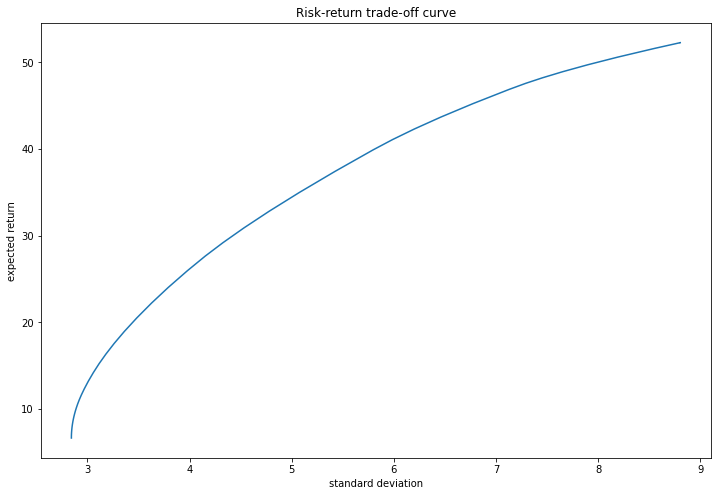

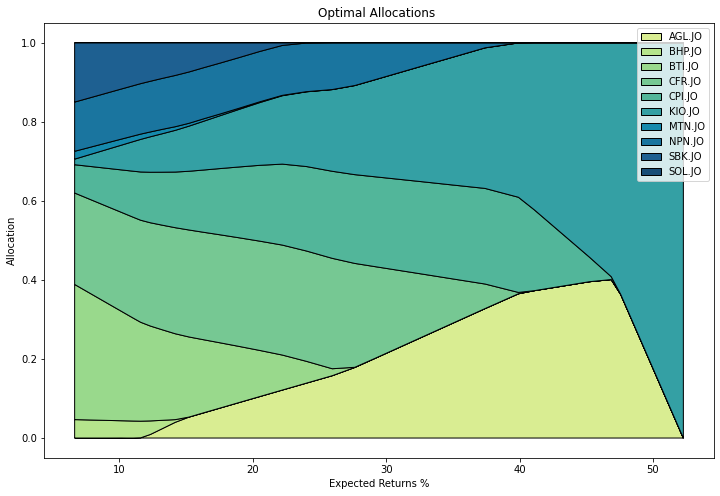

In [24]:
# Figure 4.12, page 187.
# Risk-return trade-off.

from math import sqrt
from cvxopt import matrix
from cvxopt.blas import dot 
from cvxopt.solvers import qp, options 

n = 10
S = cov
pbar = matrix(gmean)

G = matrix(0.0, (n,n))
G[::n+1] = -1.0
h = matrix(0.0, (n,1))
A = matrix(1.0, (1,n))
b = matrix(1.0)

N = 100
mus = [ 10**(5.0*t/N-1.0) for t in range(N) ]
options['show_progress'] = False
xs = [ qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus ]
returns = [ 25200*dot(pbar,x) for x in xs ]
risks = [ 252*sqrt(dot(x, S*x)) for x in xs ]


try: import pylab
except ImportError: pass
else:
    pylab.figure(1, facecolor='w')
    pylab.plot(risks, returns)
    pylab.xlabel('standard deviation')
    pylab.ylabel('expected return')
#     pylab.axis([0, 0.2, 0, 0.15])
    pylab.title('Risk-return trade-off curve')
#     pylab.yticks([0.00, 0.1, 0.20, 0.3])
    
    pylab.figure(2, facecolor='w')
    c1 = [ x[0] for x in xs ] 
    c2 = [ x[0] + x[1] for x in xs ]
    c3 = [ x[0] + x[1] + x[2] for x in xs ] 
    c4 = [ x[0] + x[1] + x[2] + x[3] for x in xs ]
    c5 = [ x[0] + x[1] + x[2] + x[3] + x[4] for x in xs ]
    c6 = [ x[0] + x[1] + x[2] + x[3] + x[4] + x[5] for x in xs ]
    c7 = [ x[0] + x[1] + x[2] + x[3] + x[4] + x[5] + x[6] for x in xs ]
    c8 = [ x[0] + x[1] + x[2] + x[3] + x[4] + x[5] + x[6]+ x[7] for x in xs ]
    c9 = [ x[0] + x[1] + x[2] + x[3] + x[4] + x[5] + x[6]+ x[7] + x[8] for x in xs ]
    c10 = [ x[0] + x[1] + x[2] + x[3] + x[4] + x[5] + x[6]+ x[7] + x[8] +x[9] for x in xs ]
    
    
    pylab.fill(returns + [50], c1 + [0], facecolor = '#d9ed92',
        edgecolor = 'black') 
    pylab.fill(returns[-1::-1] + returns, c2[-1::-1] + c1, 
        facecolor = '#b5e48c', edgecolor = 'black') 
    pylab.fill(returns[-1::-1] + returns, c3[-1::-1] + c2, 
        facecolor = '#99d98c', edgecolor = 'black' ) 
    pylab.fill(returns[-1::-1] + returns, c4[-1::-1] + c3, 
        facecolor = '#76c893', edgecolor = 'black' ) 
    pylab.fill(returns[-1::-1] + returns, c5[-1::-1] + c4, 
        facecolor = '#52b69a', edgecolor = 'black' ) 
    pylab.fill(returns[-1::-1] + returns, c6[-1::-1] + c5, 
        facecolor = '#34a0a4', edgecolor = 'black' ) 
    pylab.fill(returns[-1::-1] + returns, c7[-1::-1] + c6, 
        facecolor = '#168aad', edgecolor = 'black' ) 
    pylab.fill(returns[-1::-1] + returns, c8[-1::-1] + c7, 
        facecolor = '#1a759f', edgecolor = 'black' ) 
    pylab.fill(returns[-1::-1] + returns, c9[-1::-1] + c8, 
        facecolor = '#1e6091', edgecolor = 'black' ) 
    pylab.fill(returns[-1::-1] + returns, c10[-1::-1] + c9, 
        facecolor = '#184e77', edgecolor = 'black' ) 
    
    pylab.xlabel('Expected Returns %')
    pylab.ylabel('Allocation')
    pylab.title('Optimal Allocations ')
    pylab.legend(rates.columns)
    pylab.show()